# Exp: implement one simple standard denoising diffusion model on StanfordCars dataset

## Step0: set the environment

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # when the dataset is large, it's easy to be out of memory, then use this code

In [79]:
import math
import numpy as np
import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.datasets import StanfordCars
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Step1: load the StanfordCars dataset

In [14]:
# reshape image size
img_size = 64
# define the image transform to train
transform = transforms.Compose([
    transforms.Resize([img_size, img_size]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # transforms from (pillow,HWC,uint8,[0,255]), to (tensor,CHW,float,[0,1])
    transforms.Lambda(lambda t: t*2-1) # [0,1] => [-1,1]
])
# define the reverse image transform to show
rev_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2.), # [-1,1] => [0,1]
    transforms.Lambda(lambda t: t.permute(1,2,0)), # CHW => HWC
    transforms.Lambda(lambda t: t * 255.), # [0,1] => [0,255]
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)), # tensor,float => numpy,uint8
    transforms.ToPILImage() # numpy => PIL
])

In [10]:
# load the dataset
train_dataset = StanfordCars(root=".", download=True, transform=transform, split="train")
test_dataset = StanfordCars(root=".", download=True, transform=transform, split="test")
dataset = ConcatDataset([train_dataset, test_dataset]) # concat the two datasets as one, cuz we dont need test dataset

Using downloaded and verified file: stanford_cars\car_devkit.tgz
Extracting stanford_cars\car_devkit.tgz to stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting stanford_cars\cars_test.tgz to stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

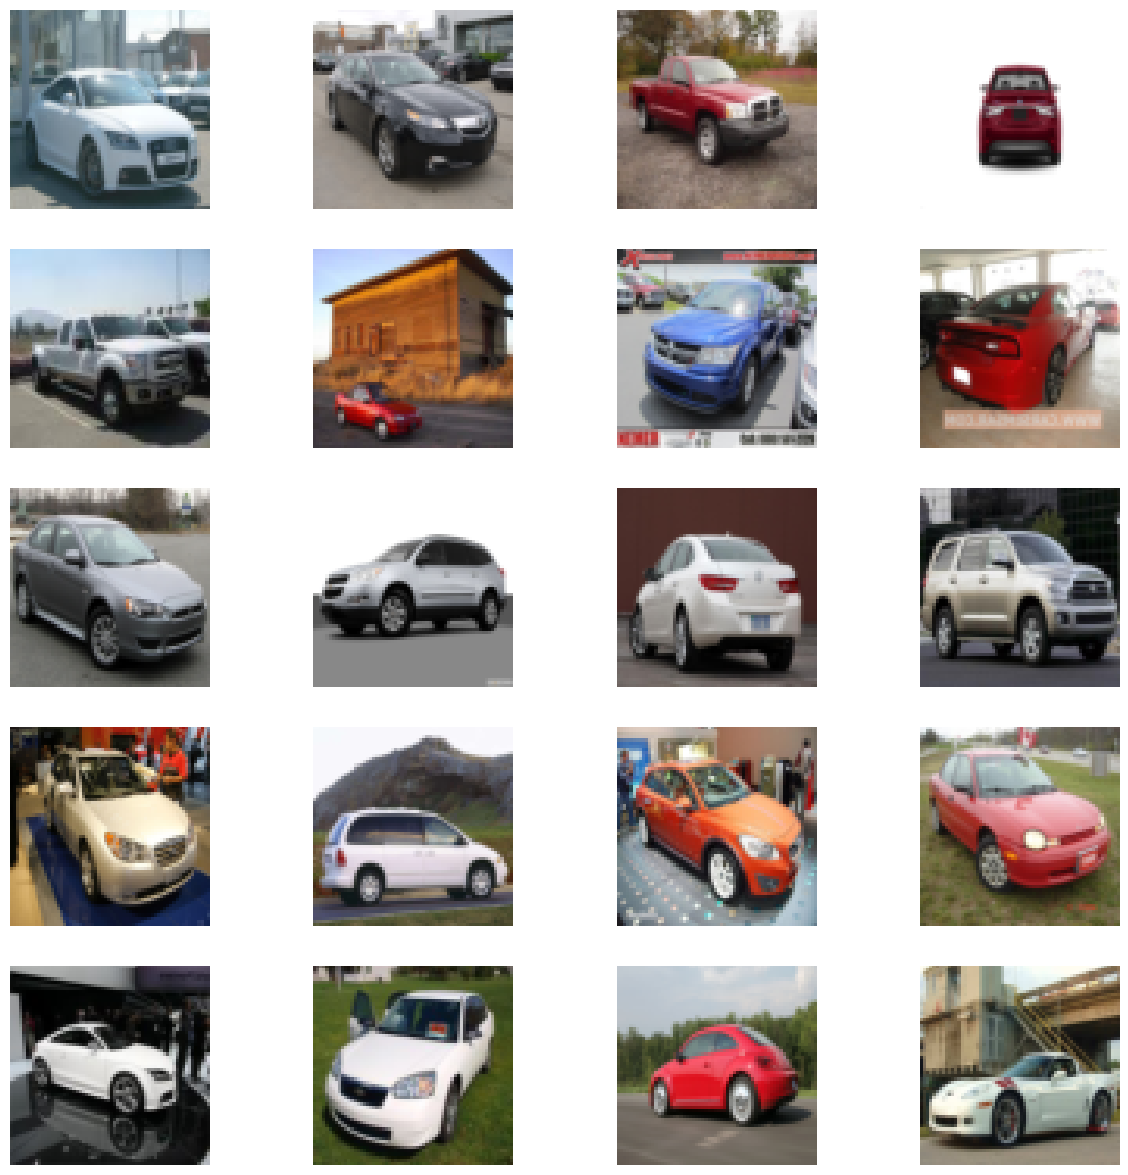

In [38]:
# show some data
def show_data(dataset, num_sample=20, cols=4):
    plt.figure(figsize=(15,15))
    rows = num_sample // cols
    for i, img in enumerate(dataset):
        if i == num_sample:
            break
        plt.subplot(rows, cols, i+1)
        plt.axis("off")
        img = rev_transform(img[0]) # transform tensor image back to PIL image
        plt.imshow(img)
show_data(dataset)

In [18]:
# construct the dataloader
batch_size = 64
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, # shuffle the whole data index list for each epoch iterations
                        drop_last=True, # drop the last incomplete batch
                       )

## Step2: build the diffusion model

### Step2.0: build the generative neural networks

In [104]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim, up=False):
        super().__init__()
        
        # time embedding layer
        self.time_embedding = nn.Linear(time_embed_dim, out_channels)
        
        # conv layer 1 and sampling transform layer
        if up: # up sampling
            self.conv1 = nn.Conv2d(2 * in_channels, out_channels, 3, padding=1) # 2 for (x, residual x)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        else: # down sampling
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)
            
        # conv layer 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
        # pool layer
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # norm and activation layer
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        # get feature map from conv layer 1
        x = self.bnorm(self.relu(self.conv1(x)))
        # embed time
        time_emb = self.relu(self.time_embedding(t))
        time_emb = time_emb[(...,) + (None,) * 2] # extend the last two layers to align with h
        # add time embedding to feature map
        x += time_emb
        
        # get feature map from conv layer 2
        x = self.bnorm(self.relu(self.conv2(x)))
        
        # down/up sampling
        return self.transform(x)

In [105]:
class SinTimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        
    def forward(self, t):
        half_dim = self.embed_dim // 2
        embed = -math.log(10000) / (half_dim - 1)
        embed = torch.exp(
            torch.arange(half_dim, device=t.device) * embed
        )
        embed = t[:, None] * embed[None, :]
        embed = torch.concat([embed.sin(), embed.cos()], dim=-1)
        return embed

In [109]:
class SimpleUNet(nn.Module):
    def __init__(self, img_size, down_channels=None, up_channels=None):
        super().__init__()
        # dim and channels
        img_channel=3
        out_dim = 1
        time_embed_dim = 32
        
        if not down_channels:
            down_channels = (64, 128, 256, 512, 1024)
        if not up_channels:
            up_channels = (1024, 512, 256, 128, 64)
        
        # time embedding, shape=(batch_size, time_embed_dim)
        self.time_embedding_layer = nn.Sequential(
            SinTimeEmbedding(time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.ReLU()
        )
        
        # down sampling conv layer
        self.down_conv0 = nn.Conv2d(img_channel, down_channels[0], kernel_size=3, padding=1)
        self.down_convs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_embed_dim)
            for i in range(len(down_channels)-1)
        ])
        
        # up sampling conv layer
        self.up_convs = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_embed_dim, up=True)
            for i in range(len(up_channels)-1)
        ])
        
        # output
        self.output = nn.Conv2d(up_channels[-1], img_channel, out_dim)
        
    def forward(self, x, t):
        # embed time
        t = self.time_embedding_layer(t)
        # get fist feature map
        x = self.down_conv0(x)
        
        # down sampling
        residual = []
        for down_conv in self.down_convs:
            x = down_conv(x, t) # in each conv layer, we should give it timestep embedding
            residual.append(x)
        # up sampling
        for up_conv in self.up_convs:
            res = residual.pop()
            x = torch.concat([x, res], dim=1) # residual connection
            x = up_conv(x, t)
        
        return self.output(x)

In [110]:
model = SimpleUNet(img_size=img_size)
print("num of params: {}".format(sum(p.numel() for p in model.parameters())))

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
model

num of params: 62433123


SimpleUNet(
  (time_embedding_layer): Sequential(
    (0): SinTimeEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (down_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_convs): ModuleList(
    (0): Block(
      (time_embedding): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_embedding): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

### Step2.1: noise scheduler (forward process)

adding noise by a T-steps Markov chain:

$$
q(x_{1:T}|x_0) = \prod\limits_{t=1}^T q(x_t|x_{t-1})\\
\text{where}\; q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_{t}I)
$$

the larger $\beta_{t}\in(0,1)$ is, the more corrupted $x_t$ will be, cuz the conditional distribution will be shifted and wider 

usually the $\beta_t$ will be (linearly) larger as the $t$ increases one by one

In [19]:
def linear_beta_scheduler(start=1e-4, end=0.2, timesteps=1000):
    # beta linearly inscreases from start to end over timesteps 
    return torch.linspace(start, end, timesteps)

In [96]:
# define the forward timesteps and construct beta in a linear form
T = 200
betas = linear_beta_scheduler(timesteps=T)
betas = betas.to(device)
betas.shape

torch.Size([200])

due to Gaussian distribution, we can get conditional distribution of any $x_t$ given $x_0$, instead of $x_{t-1}$:

$$\begin{aligned}
&q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\alpha_t'}x_{0}, (1-\alpha_t')I) = \sqrt{\alpha_t'} x_0 + \sqrt{1-\alpha_t'}\varepsilon_t\\
&\text{where}\; \alpha_t' = \prod\limits_{s=1}^t \alpha_s = \prod\limits_{s=1}^t (1-\beta_s), \varepsilon_t \sim \mathcal{N}(0,1)
\end{aligned}$$

so we can sample a subset $\mathcal{S}$ of $\mathcal{T}=\{t_0,t_1,..,t_T\}$ to use $x_{\mathcal{S}}$ as the input for the neural networks,instead of the whole $x_{\mathcal{T}}$

In [98]:
# pre-calculate alphas, alphas_prime and something else relevant to forward diffusion given betas
alphas = 1. - betas
sqrt_alphas = torch.sqrt(alphas)

alphas_prime = torch.cumprod(alphas, axis=0)
sqrt_alphas_prime = torch.sqrt(alphas_prime)

oneminus_alphas_prime = 1. - alphas_prime
sqrt_oneminus_alphas_prime = torch.sqrt(oneminus_alphas_prime)

In [88]:
def forward_diffusion_sample(x0, t, device="cpu"):
    # given x0 and timestep t, return xt and et on device
    et = torch.rand_like(x0)
    xt = sqrt_alphas_prime[t] * x0 + sqrt_oneminus_alphas_prime[t] * et
    
    return xt, et

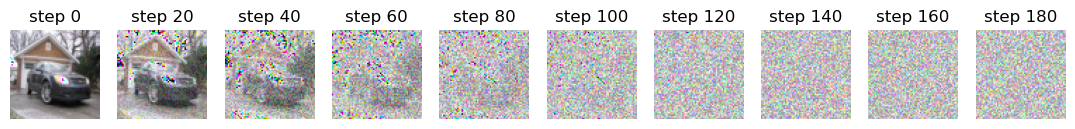

In [70]:
# simulate forward diffusion for example
x0 = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))

num_samples = 10
stepsize = int(T/num_samples)

for i in range(0, T, stepsize):
    t = torch.Tensor([i]).type(torch.int64)
    plt.subplot(1, num_samples+1, (i//stepsize)+1)
    plt.axis("off")
    plt.title("step {}".format(t.item()))
    xt, et = forward_diffusion_sample(x0, t)
    img = rev_transform(xt[0]) # show the first image in the first batch
    plt.imshow(img)

### Step2.2: denoise reconstruct (backward process) 

the backward denoising process is also a Markov process, in which the conditional probability distribution is governed by the weights $\theta$ of th neural networks:

$$
p_{\theta}(x_{0:T}) = p(x_T) \prod\limits_{t=1}^T p_{\theta}(x_{t-1}|x_t)\\
\text{where}\; p(x_T) = \mathcal{N}(x_T;0,I)
$$

we can equivalently use the networks to predict the noise $\varepsilon_t$ adding to $x_0$ to become $x_{t}$, so the loss function will be:

$$
loss = \mathbf{E}_{x_0,\; t,\; \varepsilon} [ ||\varepsilon_t - \tilde\varepsilon_t|| ]\\
\tilde\varepsilon_t = \varepsilon_{\theta}(x_t, t), x_t = \text{diffusion}(x_0, t)
$$

In [112]:
def get_loss(model, x0, t, device="cpu"):
    xt, et = forward_diffusion_sample(x0, t, device)
    et_pred = model(xt, t)
    
    loss = F.l1_loss(et, et_pred)
    
    return loss

after training the model and assuming it really can predict the noise $\tilde\varepsilon_t \approx \varepsilon_t$ on $x_0$ at time step $t$, then we can recover $x_{t-1}$ using $x_t, \tilde\varepsilon_t$ by:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{\beta_t}{\sqrt{1-\alpha_t'}}\cdot \tilde\varepsilon_t) + \sigma_t z\\
\text{where}\; \sigma_t = \frac{1-\alpha_{t-1}'}{1-\alpha_t'}\beta_t, z\sim \mathcal{N}(0,1)
$$

In [76]:
def backward_denoise_sample(model, xt, t):
    with torch.no_grad():
        et_pred = model(xt, t)
        z = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)

        sigma_t = oneminus_alphas_prime[t-1] / oneminus_alphas_prime[t] * betas[t]

        mean_t = 1. / sqrt_alphas[t] * (
            xt - betas[t] / sqrt_oneminus_alphas_prime[t] * et_pred
        )

        xt_prev = mean_t + sigma_t * z # x_{t-1}

        return xt_prev

In [114]:
def plot_backward_sample_image(model, device, batch_size=1):
    img = torch.randn((batch_size,3,img_size,img_size), device=device)
    
    plt.figure(figsize=(15,15))
    num_samples = 10
    stepsize = int(T/num_samples)
    
    for i in range(0, T)[::-1]:
        t = torch.Tensor([i]).long().to(device)
        img = backward_denoise_sample(model, img, t)
        
        if i % stepsize == 0: # show every stepsize denoised image
            for b in range(batch_size):
                plt.subplot(batch_size, num_samples+1, b * stepsize + (i//stepsize)+1)
                plt.axis("off")
                if b == 0:
                    plt.title("step {}".format(t.item()))
                plt.imshow(rev_transform(img[b].detach().cpu()))

### Step3: train the model

In [ ]:
model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.
    for i, batch in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        
        # randomly sampling step t
        t = torch.randint(0, T, (1,)).long().to(device)
        x0 = batch[0].to(device)
        
        # loss backpropagation
        loss = get_loss(model, x0, t, device)
        train_loss += loss
        loss.backward()
        
        # update the weights
        optimizer.step()

    train_loss /= len(dataloader)
    print("Epoch: {} | Loss: {}".format(train_loss.item()))
    if epoch % 5 == 0:
        plot_backward_sample_image(model, device)

### Step4: test the model

In [ ]:
test_batch = 5
plot_backward_sample_image(model, device, test_batch)